# Theme of this notebook - How to optimize a portfolio risk
* This is a memo for optimizing a portforio risk by using CVXPY

In [33]:
# First, install pandas-datareader to load financial data from Yahoo Finance
! pip install pandas-datareader

In [34]:
# Import libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import yfinance as yf
import datetime as dt

#Note 1: Problem of Yahoo Finance Data 1
* Yahoo Fiance data has a survivorship bias.
* Stock prices of companies that are no longer in the stock market due to bankruptcy, delisting, etc. cannot be obtained. (e.g., due to the merger of Credit Suisse and Barclays Securities, the stock price of Credit Suisse can no longer be obtained)

#Note 2: Problem of Yahoo Finance Data 2
* Yahoo Fiance data does not reflect convertible bonds.
* Therefore, we should consider the dilution of stock value by adding convertible bonds when we calculate enterprize values.

In [35]:
# Let's make a portfolio consisting of three stocks as a sample.
apple = yf.download('AAPL', start='1980-09-10', end=dt.date.today())
goldman = yf.download('GS', start='1980-09-10', end=dt.date.today())
walmart = yf.download('WMT', start='1980-09-10', end=dt.date.today())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


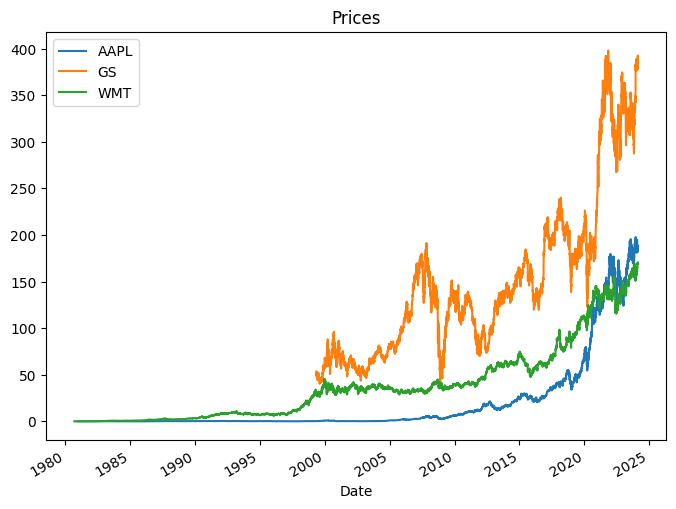

In [36]:
# Visualize each price
plt.figure(figsize=(8,6))

apple['Adj Close'].plot(label='AAPL')
goldman['Adj Close'].plot(label='GS')
walmart['Adj Close'].plot(label='WMT')

plt.title('Prices')
plt.legend()

<Axes: ylabel='Frequency'>

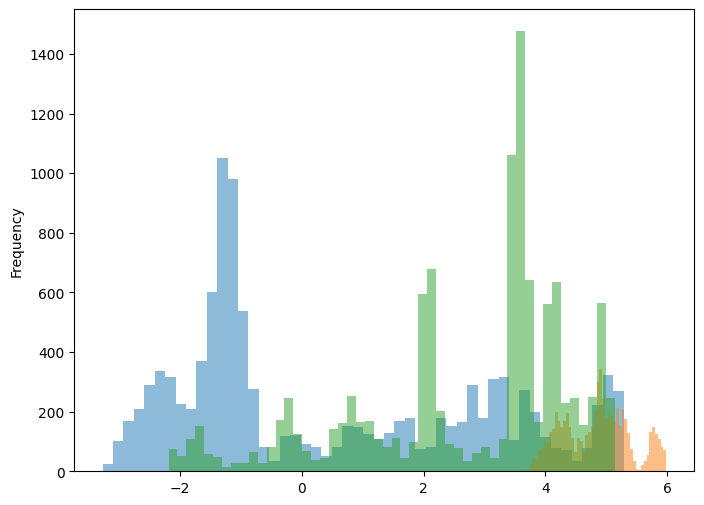

In [37]:
# Crate graph of logarithmic returns of each stock
plt.figure(figsize=(8,6))

np.log(apple['Adj Close']).plot(kind='hist', bins=50, alpha=0.5)
np.log(goldman['Adj Close']).plot(kind='hist', bins=50, alpha=0.5)
np.log(walmart['Adj Close']).plot(kind='hist', bins=50, alpha=0.5)

In [38]:
# Let's check returns in the last two years
today = dt.date.today()
two_years_ago = today - dt.timedelta(days=2*365)

In [39]:
# Create a new DataFrame to store returns
returns = pd.DataFrame()

In [40]:
# Calculate each stock's return in the last two years
returns['AAPL_ret'] = (apple.loc[two_years_ago:today, 'Adj Close'] / apple.loc[two_years_ago:today, 'Adj Close'].shift()) - 1
returns['GS_ret'] = (goldman.loc[two_years_ago:today, 'Adj Close'] / goldman.loc[two_years_ago:today, 'Adj Close'].shift()) - 1
returns['WMT_ret'] = (walmart.loc[two_years_ago:today, 'Adj Close'] / walmart.loc[two_years_ago:today, 'Adj Close'].shift()) - 1
returns

,AAPL_ret,GS_ret,WMT_ret
Date,,,
2022-02-17,NaN,NaN,NaN
2022-02-18,-0.009356,-0.008652,-0.006408
2022-02-22,-0.017812,-0.005115,-0.011160
2022-02-23,-0.025864,-0.008946,-0.010260
2022-02-24,0.016680,-0.002931,-0.003850
...,...,...,...
2024-02-12,-0.009002,0.021808,0.006026
2024-02-13,-0.011274,-0.035376,-0.006812
2024-02-14,-0.004810,-0.001875,-0.003193


<Axes: xlabel='Date'>

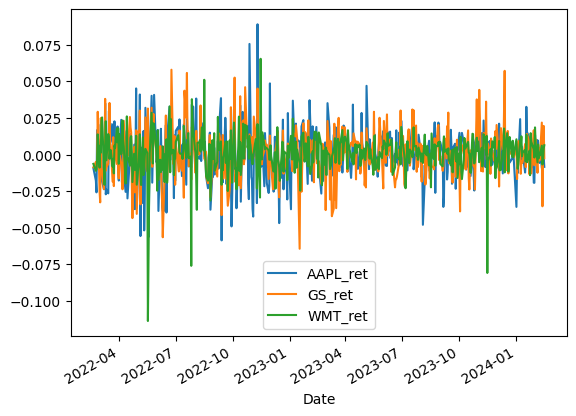

In [41]:
returns.plot()

<Axes: ylabel='Frequency'>

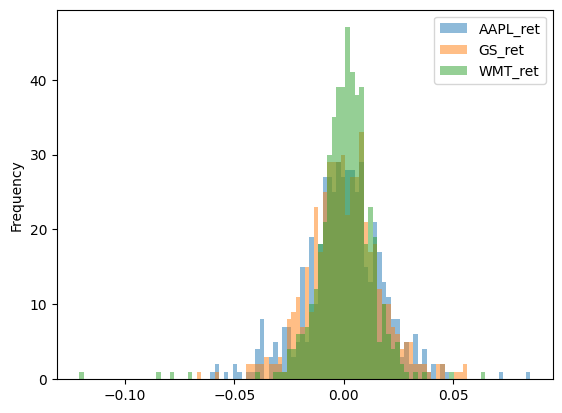

In [42]:
np.log(returns+1).plot(kind='hist', bins=100, alpha=0.5)

In [43]:
# Calculate returns' mean and volatility
mean_vola = pd.DataFrame({'Mean': returns.mean(),
                          'Volatility': returns.std()})
mean_vola

,Mean,Volatility
AAPL_ret,0.000336,0.017971
GS_ret,0.000441,0.016415
WMT_ret,0.000563,0.013560


In [44]:
# Calculate correlation coefficiences among each stock
corr_matrix = returns.corr()
corr_matrix

,AAPL_ret,GS_ret,WMT_ret
AAPL_ret,1.000000,0.480829,0.302069
GS_ret,0.480829,1.000000,0.216750
WMT_ret,0.302069,0.216750,1.000000


In [45]:
# Calculate covariances among each stock
covariance_matrix = returns.cov()
covariance_matrix

,AAPL_ret,GS_ret,WMT_ret
AAPL_ret,0.000323,0.000142,0.000074
GS_ret,0.000142,0.000269,0.000048
WMT_ret,0.000074,0.000048,0.000184


In [46]:
# marge mean, volatility, and correlation coefficience into one table
mean_vola_corr = pd.concat([mean_vola, corr_matrix], axis=1)
mean_vola_corr

,Mean,Volatility,AAPL_ret,GS_ret,WMT_ret
AAPL_ret,0.000336,0.017971,1.000000,0.480829,0.302069
GS_ret,0.000441,0.016415,0.480829,1.000000,0.216750
WMT_ret,0.000563,0.013560,0.302069,0.216750,1.000000


# Problem: how should we allocate each stock to minimize the portfolio risk?
Let's split problem into the following steps
1. Determine decision variables
2. Identify Objectibe function
3. Identify constraints
4. Solve the optimization problem

# 1. Decision variables
<br>
<font>
    <ul>
        <li>What are the problem's decision variables?</li>
        <br>
        <li>\begin{align}
        w_1 & = \text{ fraction invested in security 1} \\
        w_2 & = \text{ fraction invested in security 2} \\
        w_3 & = \text{ fraction invested in security 3} \\
        \end{align}</li>
        <br>
    </ul>
</font>

In [47]:
# set decision variables by using cvxpy.Variable
portfolio_weights = cp.Variable(len(mean_vola_corr))

weight_aapl = portfolio_weights[0]
weight_gs = portfolio_weights[1]
weight_wmt = portfolio_weights[2]

#2. Objective function

<li>The objective is to minimize the overall portfolio risk. In other words;</li>
        <br>
        <li>\begin{align}
        \text{minimize: } & risk(w_1, w_2, w_3) \\
        \end{align}</li>
        <br>
        <li>Equivalently, \begin{align}
        \text{minimize: } & [ w_1^2 \sigma^2(r_1) + w_2^2 \sigma^2(r_2)  + w_3^2 \sigma^2(r_3) \\
        &+ 2 w_1 w_2 \sigma(r_1) \sigma(r_2) \rho_{r_1, r_2} \\
        &+ 2 w_1 w_3 \sigma(r_1) \sigma(r_3) \rho_{r_1, r_3} \\
        &+ 2 w_2 w_3 \sigma(r_2) \sigma(r_3) \rho_{r_2, r_3} ]^{\frac{1}{2}} \\
        \end{align}</li>
        <li>Where:<br>
            expected return $\mathbb{E}[r_p]$, variance $\sigma^2(r_i)$, standard deviations $\sigma(r_i)$, also known as volatility, and cross-correlations $\rho_{r_i, r_j}$.
        </li>

<b>[Important] We can rewrite the following formula into the quadratic form!</b>
        <li>\begin{align}
        \text{minimize: } & risk(w_1, w_2, w_3) \\
        \end{align}</li>
        <br>
        <li>\begin{align}⇩\end{align}</li>
        <li>\begin{equation}risk(w_1, w_2, w_3)^2 =
        \underbrace{\begin{bmatrix}
        w_1 & w_2 & w_3 \\
        \end{bmatrix}}_{\underbrace{\bar{w}^T}_{(1\times 3)}}
        \underbrace{\begin{bmatrix}
Cov(r_1,r_1) & Cov(r_1, r_2) & Cov(r_1, r_3)\\
Cov(r_2, r_1) & Cov(r_2, r_2) & Cov(r_2, r_3) \\
Cov(r_3, r_1) & Cov(r_3, r_2) & Cov(r_3, r_3) \\
            \end{bmatrix}}_{\underbrace{\Sigma}_{(3\times 3)}}
            \underbrace{\begin{bmatrix}
        w_1 \\ w_2 \\ w_3 \\
        \end{bmatrix}}_{\underbrace{\bar{w}}_{(3\times 1)}}\end{equation}</li>
        <br>

In [48]:
# Create covariance matrix
covariance_matrix = returns.cov()
covariance_matrix

,AAPL_ret,GS_ret,WMT_ret
AAPL_ret,0.000323,0.000142,0.000074
GS_ret,0.000142,0.000269,0.000048
WMT_ret,0.000074,0.000048,0.000184


In [49]:
# Set objective function by using cvxpy.Minimize and cvxpy.quad_form
# The following code means "to minimize the second quadratic formula"
objective = cp.Minimize(cp.quad_form(portfolio_weights, covariance_matrix))

#3. Constraints

* Assume that a client want to archive the following conditions

<li>\begin{align}
    \text{subject to: }
    & \mathbb{E}[r_p] = w_1 \mathbb{E}[r_1] + w_2 \mathbb{E}[r_2] + w_3 \mathbb{E}[r_3] & \geq 0.0003 & \text{ (required return)}\\
    & w_1, w_2, w_3  & \geq 0  & \text{ (no short-selling, long only)}\\
    & w_1, w_2, w_3  & \leq 1 & \text{ (no margin/leverage)}\\
    & w_1 + w_2 + w_3  &  = 1 & \text{ (fully invested)}\\
    &  w_1 & \geq 0.33  & \text{ (required exposure to AAPL)}\\
    \end{align}</li>
       

In [50]:
# Define parameters for mean return by using cvxpy.Parameter
# Average return of Microsoft
avg_ret_apple = cp.Parameter()
avg_ret_apple.value = mean_vola_corr.loc['AAPL_ret', 'Mean']

# Average return of Visa
avg_ret_goldman = cp.Parameter()
avg_ret_goldman.value = mean_vola_corr.loc['GS_ret', 'Mean']

# Average return of Walmart
avg_ret_walmart = cp.Parameter()
avg_ret_walmart.value = mean_vola_corr.loc['WMT_ret', 'Mean']

In [51]:
# Implement each constraint by using cvxpy.Parameter
req_return = cp.Parameter()
req_return.value = 0.0003

# Condition1: Total return must be better than 0.0003
constraint_required_return = [(weight_aapl*avg_ret_apple \
                              + weight_gs*avg_ret_goldman \
                              + weight_wmt*avg_ret_walmart >= req_return)]

# Condition2: Long only
constraint_no_short_selling = [weight_aapl >= 0,
                              weight_gs >= 0,
                              weight_wmt >= 0]
# Condition3: No leverage
constraint_no_leverage = [weight_aapl <= 1,
                          weight_gs <= 1,
                          weight_wmt <= 1]

# Condition4: The total of all weights = 1
constraint_fully_vested = [weight_aapl + weight_gs + weight_wmt == 1]

# Condition5: The client want to set the weight to Apple over 33%
req_aapl_exposure = cp.Parameter()
req_aapl_exposure.value = 0.33
constraint_required_aapl_exposure = [weight_aapl >= req_aapl_exposure]

# Merge all constraints
constraints = constraint_required_return + \
            constraint_no_short_selling + \
            constraint_no_leverage + \
            constraint_fully_vested + \
            constraint_required_aapl_exposure

#4. Solve the optimization problem

In [52]:
# Set problem fuction by using cvxpy.Problem
prob = cp.Problem(objective, constraints)

In [53]:
# Solve the problem
prob.solve()

0.00013716807207684483

In [54]:
prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Feb 17 08:22:14 AM: Your problem has 3 variables, 9 constraints, and 5 parameters.
(CVXPY) Feb 17 08:22:14 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 17 08:22:14 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 17 08:22:14 AM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Feb 17 08:22:14 AM: Finished problem compilation (took 6.258e-03 seconds).
-------------------------------------------------------------------------------
                                

0.00013716807207684475

In [55]:
weight_aapl.value, weight_gs.value, weight_wmt.value

(0.32999999999999996, 0.19155208369358506, 0.47844791630641476)

In [56]:
try:
    prob.solve()
    print ("Optimal portfolio")
    print ("----------------------")
    for s in range(len(mean_vola_corr)):
        print (" Investment in {} : {}% of the portfolio".format(mean_vola_corr.index[s],
                                                                 round(100*portfolio_weights.value[s],2)))
    print ("----------------------")
    print ("Exp ret = {}%".format(round(100*((portfolio_weights.value.T)@(mean_vola_corr['Mean'])),2)))
    print ("Expected risk    = {}%".format(round(100*((cp.quad_form(portfolio_weights.value, covariance_matrix).value)**(1/2)),2)))
except:
    print ("Error")

Optimal portfolio
----------------------
 Investment in AAPL_ret : 33.0% of the portfolio
 Investment in GS_ret : 19.16% of the portfolio
 Investment in WMT_ret : 47.84% of the portfolio
----------------------
Exp ret = 0.05%
Expected risk    = 1.17%


# Conclusition
* By using CVXPY, we can optimize portforio risk with maximizing its return